<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/%E6%A7%98%E3%80%85%E3%81%AA%E6%AD%A3%E8%A6%8F%E5%8C%96%E3%81%A8K%E8%BF%91%E5%82%8D%E6%B3%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
# k近傍法 (kNN) 異常検知：標準化 vs 固有ベクトル回転のみ vs ホワイトニング（1セル）
# 手順:
# 1) 2次元の相関あり正規から学習(正常)とテスト(正常+異常)を作成
# 2) 変換を選ぶ： "standardize" / "rotate_only" / "whiten"
#    - rotate_only: 固有ベクトルで直交変換だけ（距離は不変 → kNN結果も基本同じ）
#    - whiten: 固有値で割って分散=1に（Mahalanobis=Euclideanになり結果が変わり得る）
# 3) 学習スコアの上位α分位をしきい値にして異常判定
# 4) 可視化（散布図+等高線、スコアのヒスト）

import numpy as np
import matplotlib.pyplot as plt



In [46]:
np.random.seed(0)

In [47]:
# ===== パラメータ =====
mode = "whiten"   # "standardize" / "rotate_only" / "whiten" を切替
k = 10            # 近傍数
alpha = 0.99      # 学習スコアの上位α分位点をしきい値に
n_train = 400
n_test_norm = 200
n_test_out = 20

In [48]:
# ===== 1) データ作成（相関ありガウス） =====
mu = np.array([0.0, 0.0])
Sigma = np.array([[3.0, 2.0],
                  [2.0, 5.0]])   # 相関あり
train = np.random.multivariate_normal(mu, Sigma, size=n_train)         # 学習：正常
test_norm = np.random.multivariate_normal(mu, Sigma, size=n_test_norm) # テスト：正常

# 異常は平均をずらす
mu_out = np.array([6.0, -6.0])
Sigma_out = np.array([[1.0, 0.2],
                      [0.2, 1.0]])
test_out = np.random.multivariate_normal(mu_out, Sigma_out, size=n_test_out)

test = np.vstack([test_norm, test_out])
labels = np.hstack([np.zeros(len(test_norm), dtype=int), np.ones(len(test_out), dtype=int)])

In [49]:
# ===== 2) 変換の準備 =====
# まずは学習データでZ標準化（中心化+スケール合わせ）
mu_hat = train.mean(axis=0)
std_hat = train.std(axis=0, ddof=1)
std_hat = np.where(std_hat == 0, 1.0, std_hat)

train_z = (train - mu_hat) / std_hat
test_z  = (test  - mu_hat) / std_hat

# 標準化後の共分散（相関行列）。ここから固有ベクトル/固有値を取る
Cov_z = np.cov(train_z, rowvar=False)
evals, evecs = np.linalg.eigh(Cov_z)  # evals>=0, evecsは直交

def apply_transform(Xz, mode):
    if mode == "standardize":
        # 追加変換なし
        return Xz
    elif mode == "rotate_only":
        # 直交回転のみ（距離は不変）
        return Xz @ evecs
    elif mode == "whiten":
        # ホワイトニング：固有値で割る（Λ^{-1/2}）
        Lm12 = np.diag(evals**-0.5)
        return Xz @ evecs @ Lm12
    else:
        raise ValueError("mode must be 'standardize' | 'rotate_only' | 'whiten'")

train_tr = apply_transform(train_z, mode)
test_tr  = apply_transform(test_z, mode)

In [50]:
# （おまけ）回転のみで距離が変わらないことを確認
def pairwise_l2(A, B):
    A2 = np.sum(A*A, axis=1, keepdims=True)
    B2 = np.sum(B*B, axis=1, keepdims=True).T
    D2 = A2 + B2 - 2*(A @ B.T)
    D2 = np.maximum(D2, 0.0)
    return np.sqrt(D2)
if mode == "rotate_only":
    d0 = pairwise_l2(test_z, train_z)
    d1 = pairwise_l2(test_tr, train_tr)
    print("max|distance(original)-distance(rotated)| =", float(np.max(np.abs(d0 - d1))))

max|distance(original)-distance(rotated)| = 2.1621593404574924e-14


In [51]:
# ===== 3) k近傍距離スコア =====
# 学習スコア（自己点除外）
dist_train = pairwise_l2(train_tr, train_tr)
np.fill_diagonal(dist_train, np.inf)
idx_k_train = np.argpartition(dist_train, kth=k, axis=1)[:, :k]
row_idx = np.arange(n_train)[:, None]
score_train = dist_train[row_idx, idx_k_train].mean(axis=1)

# テストスコア（学習データへの距離）
dist_test = pairwise_l2(test_tr, train_tr)
idx_k_test = np.argpartition(dist_test, kth=k, axis=1)[:, :k]
row_idx_t = np.arange(test_tr.shape[0])[:, None]
score_test = dist_test[row_idx_t, idx_k_test].mean(axis=1)

In [52]:
# ===== 4) しきい値＆判定 =====
thr = np.quantile(score_train, alpha)
pred = (score_test > thr).astype(int)

tp = ((pred==1) & (labels==1)).sum()
fp = ((pred==1) & (labels==0)).sum()
fn = ((pred==0) & (labels==1)).sum()
precision = tp / (tp+fp) if (tp+fp)>0 else 0.0
recall    = tp / (tp+fn) if (tp+fn)>0 else 0.0

print(f"mode={mode}, k={k}, alpha={alpha}")
print(f"threshold (quantile on train scores): {thr:.4f}")
print(f"TP={tp}, FP={fp}, FN={fn}")
print(f"precision={precision:.3f}, recall={recall:.3f}")


mode=rotate_only, k=10, alpha=0.99
threshold (quantile on train scores): 0.7701
TP=20, FP=5, FN=0
precision=0.800, recall=1.000


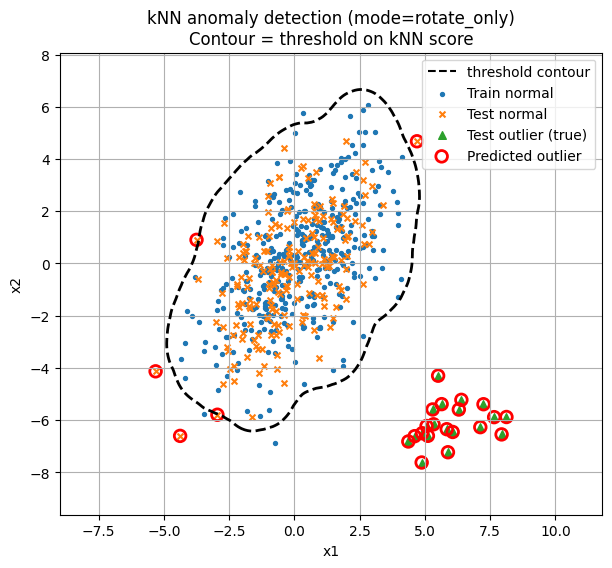

In [53]:
# ===== 5) 可視化 =====
# (a) 元の値の散布図＋等高線（変換後の空間で格子スコアを算出し、元空間に重ねて表示）
#   可視化は分かりやすさ重視で「x1-x2の座標」に描きます（変換は内部で使うだけ）
x_min, y_min = (np.min(np.vstack([train, test]), axis=0) - 2)
x_max, y_max = (np.max(np.vstack([train, test]), axis=0) + 2)
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_z = (grid - mu_hat) / std_hat
grid_tr = apply_transform(grid_z, mode)

dist_grid = pairwise_l2(grid_tr, train_tr)
idx_k_grid = np.argpartition(dist_grid, kth=k, axis=1)[:, :k]
row_idx_g = np.arange(grid_tr.shape[0])[:, None]
score_grid = dist_grid[row_idx_g, idx_k_grid].mean(axis=1).reshape(xx.shape)

plt.figure(figsize=(7,6))
# 等高線（しきい値）。凡例はダミー線で追加（環境依存属性に触らない）
plt.contour(xx, yy, score_grid, levels=[thr], linestyles='--', linewidths=2, colors='k')
plt.plot([], [], 'k--', label="threshold contour")

plt.scatter(train[:,0], train[:,1], s=8,  label="Train normal")
plt.scatter(test_norm[:,0], test_norm[:,1], s=18, marker='x', label="Test normal")
plt.scatter(test_out[:,0],  test_out[:,1],  s=30, marker='^', label="Test outlier (true)")

flag_idx = np.where(pred==1)[0]
plt.scatter(test[flag_idx,0], test[flag_idx,1], s=70, facecolors='none',
            edgecolors='red', linewidths=2, label="Predicted outlier")

plt.title(f"kNN anomaly detection (mode={mode})\nContour = threshold on kNN score")
plt.xlabel("x1"); plt.ylabel("x2")
plt.legend(loc="best"); plt.grid(True); plt.axis('equal')
plt.show()

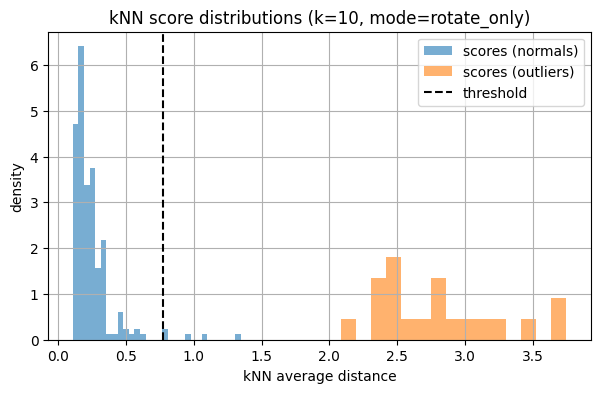

In [54]:
# (b) スコアのヒストグラム
plt.figure(figsize=(7,4))
plt.hist(score_test[labels==0], bins=30, density=True, alpha=0.6, label="scores (normals)")
plt.hist(score_test[labels==1], bins=15, density=True, alpha=0.6, label="scores (outliers)")
plt.axvline(thr, linestyle='--', color='k', label="threshold")
plt.title(f"kNN score distributions (k={k}, mode={mode})")
plt.xlabel("kNN average distance"); plt.ylabel("density")
plt.legend(); plt.grid(True)
plt.show()
